## Prepare

### Load packages

In [368]:
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import sklearn.metrics

from scipy import stats

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#TF2.0
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import activations

from time import time

import tensorflow.keras.backend as K
#from tensorflow.keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input, Layer,InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras import metrics
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ELU

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

from keras.utils.vis_utils import plot_model


seed_value= 42


import os
os.environ['PYTHONHASHSEED']=str(seed_value)


import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from keras import backend as K

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Functions

### Data Preprocessing Func

In [369]:
def data_preprocess(data_path="/content/multi_class_start_year.dta",format='stata',missing_ratio=0.79,group='AM'):
  if format == 'stata':
    data_s=pd.read_stata(data_path)
  if format == 'csv':
    data_s=pd.read_csv(data_path)

  #remove the missing variable
  data_s_AM=data_s[data_s['income']==group]
  miss_s_AM=data_s[data_s['income']==group].isnull().sum().sort_values(ascending=False)
  n=data_s_AM.shape[0]
  miss_name_idx=miss_s_AM[miss_s_AM<n*missing_ratio].index

  data_s_AM_copy=pd.DataFrame()

  for miss_name in miss_name_idx:
    size=data_s_AM[miss_name][data_s_AM[miss_name].isnull()==True].shape[0]
    sample=data_s_AM[miss_name][data_s_AM[miss_name].isnull()==False]
    re_sample=resample(sample,n_samples=size, replace= True)
    x=data_s_AM[miss_name].copy()
    x[data_s_AM[miss_name].isnull()==True]=re_sample.values
    data_s_AM_copy[miss_name]=x
    #print(miss_name)

  #quant_name=data_s_AM_copy.nunique().sort_values(ascending=True)
  #quant_name=quant_name[quant_name>invariate].index

  return data_s_AM_copy#[quant_name]

### AutoEncoder


In [370]:
def ae(input_data,encoder=[36,18,18,10]
       ,decoder=[10,18,18,36],hidden=4,train_set=0.8
       ,loss='mae',noise=0,epochs=800, batch_size=100,dropout_rate=0,activ='elu'):
  
  df=input_data
  input_dim=input_data.shape[1]
  l=input_data.shape[0]
  cut=round(l*train_set)

  
  #data splitting

  import random
  id_df=np.random.choice(l, l, replace=False)

  train=df.iloc[id_df[0:cut],:]
  test=df.iloc[id_df[cut:l],:]

  print([cut,l])

  x_train=train
  x_test=test

  x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
  x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

  
  #construct ae

  inputs = Input(shape=(input_dim,))
  encoded = Dense(encoder[0], activation='linear',kernel_initializer='lecun_normal')(inputs)
  encoded = ELU(alpha=1.0)(encoded)

  for en_l in encoder[1:]:
    encoded = Dense(en_l, activation='linear',kernel_initializer='lecun_normal')(encoded)
    encoded = ELU(alpha=1.0)(encoded)
 
  encoded = Dropout(dropout_rate)(encoded)
  #encoded = Dense(hidden, activation='linear',kernel_initializer='lecun_normal')(encoded)
  encoded = Dense(hidden, activation=activ,kernel_initializer='lecun_normal')(encoded)
  
  #decoded = ELU(alpha=1.0)(encoded)

  decoded = Dense(decoder[0], activation='linear',kernel_initializer='lecun_normal')(encoded)
  decoded = ELU(alpha=1.0)(decoded)

  for de_l in decoder[1:]:
    decoded = Dense(de_l, activation='linear',kernel_initializer='lecun_normal')(decoded)
    decoded = ELU(alpha=1.0)(decoded)

  decoded = Dense(input_dim, activation='linear',kernel_initializer='lecun_normal')(decoded)

  autoencoder = Model(inputs, decoded)

  autoencoder.compile(optimizer='adam', loss=loss)

  #training
  autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))
  
  encoder = Model(inputs, encoded)
  
  return autoencoder,encoder

### Boosted AutoEncoder

In [371]:
def boost_ae(input_data,encoder=[36,18,18,10]
       ,decoder=[10,18,18,36],hidden=4,train_set=0.8
       ,boost_n=1,loss='mae',noise=0,epochs=800, batch_size=100,dropout_rate=0):
  
  data_resid=[]

  for i in np.arange(boost_n):
    autoencoder,encoder=ae(input_data=input_data,encoder=encoder
       ,decoder=decoder,hidden=hidden,train_set=train_set
       ,loss=loss,noise=noise,epochs=epochs, batch_size=batch_size,dropout_rate=dropout_rate)
    
    rec_df=autoencoder.predict(input_data)
    input_resid=input_data-rec_df
    data_resid.append(input_resid)

  return data_resid

### Mode Contrastive Auto Encoder

In [372]:
# define the cluster layer for MCAE

class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [373]:
def mcae(input_data,trained_encoder,trained_autoencoder
         ,n_clusters=9,loss_f='mae',mc_weight=0.1
         ,maxiter = 40000,batch_size=1000,noise=0.3):
  
  autoencoder=trained_autoencoder
  encoder=trained_encoder

  #generate clusters
  code=encoder.predict(input_data)
  kmeans = KMeans(n_clusters, random_state=0).fit(code)

  #construct MCAE
  clustering_layer = ClusteringLayer(n_clusters,name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
  model.compile(optimizer='adam', loss=['categorical_crossentropy', loss_f]
                , loss_weights=[mc_weight, 1])
  
  y_pred = kmeans.fit_predict(code)
  y_pred_last = np.copy(y_pred)

  model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

  #training

  loss = 0
  index = 0
  index_array = np.arange(input_data.shape[0])
  tol = 0.00000000001

  for ite in range(int(maxiter)):
    if ite < 3000:
      update_interval=800
    if (ite > 3000) & (ite < 10000):
      update_interval=800
    if (ite > 10000) & (ite < 20000):
      update_interval=1000
    if ite > 20000:
      update_interval=1000
    
    if ite % update_interval == 0:
      q, _ = model.predict(input_data.values, verbose=0)
      y_c = q.argmax(1)
      y_pred = np.copy(y_c)
      y_c=np_utils.to_categorical(y_c,num_classes=n_clusters)
      print('Iter %d:' % (ite), ' ; loss=', loss)

      delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
      y_pred_last = np.copy(y_pred)
      if ite > 0 and delta_label < tol:
        print('delta_label ', delta_label, '< tol ', tol)
        print('Reached threshold.')
        #break
    idx = index_array[index * batch_size: min((index+1) * batch_size, input_data.shape[0])]
    loss = model.train_on_batch(x=input_data.values[idx]+noise * np.random.normal(loc=0.0, scale=1.0, size=1) , y=[y_c[idx], input_data.values[idx]])
    index = index + 1 if (index + 1) * batch_size <= input_data.shape[0] else 0

  return model, encoder


## Implement

### Read Data

In [374]:
data=data_preprocess(data_path="/content/multi_class_start_year.dta",format='stata',missing_ratio=0.81,group='AM')

#select features

data_s=data[['FCM3M_hpf','FCM3M','R_FCM10_hpf','diff_R_FCM10','R_FCM10'
,'d_REER_major_Pushfactors','FFER_Shadow_Pushfactors_1y_diff','yrs_since_epi_end'
,'episode_share','ldiff_d_5','d_d_bxgs_bp6_5','fskrc_pt','diff_d_bxgs_bp6'
,'ln_d_bxgs_bp6','d_bxgs_bp6','d_ARA_M_RES_VEE_5','ld_ratio','ndtot_c_Fiscal_gdp'
,'d_ARA_M_RES_VEE','ARA_M_RES_VEE','REALHP_5YR','REALSTOCKS_5YR','snig4','snig4_share'
,'L_DA_BA_GDP_VEE','PD_BANK_Buda','PD_XBANK_Buda','d_fsc_int_rev_5','PD_CORP_Buda'
,'ln_smin_hp','d_fsc_int_rev','d_fsc_bal_rev_5','fsc_int_rev','d_debt_revenue_5'
,'d_capflow_5','sdiff_fidr','PIR','d_fsc_bal_rev','FIA','d_debt_revenue','fsc_bal_rev'
,'FIE','netoilgain','sdiff_figb','PRR','l_debt_revenue','ldiff_enda','credit_GDP_MU_hp_real'
,'credit_GDP_MU_hp_fin','ldiff_d','d_capflow','ldiff_bxgs_bp6_5','ldiff_reer','capflow'
,'growth_volatility','sdiff_fidr_r','d_pvd_ls_GDD_5','d_bca_gdp_bp6_5','d_NGDP_R_PCH_WX001_VELIC_5'
,'ldiff_bxgs_bp6','NGDP_R_PCH_WX001_VELIC','ldiff_enda_5','pcpi_pch_cum','d_ln_bca_gdp_bp6'
,'d_pvd_ls_GDD','d_ln_tt','ln_pvd_ls_GDD','ln_bca_gdp_bp6','cred_gdp','bca_gdp_bp6'
,'reserves_Fiscal_gdp','ppppc_rel','pcpi_pch_log','ngap_r_hpf','ngdp_rpch']].copy()

#standardize

scaler = preprocessing.StandardScaler().fit(data_s)
data_s = pd.DataFrame(scaler.transform(data_s)).copy()

### variables

var_class=data['class'].copy()
var_year=data['year'].copy()
var_country=data['country_name'].copy()

In [375]:
data_s.shape

(1688, 75)

### Visualization (Round 0)

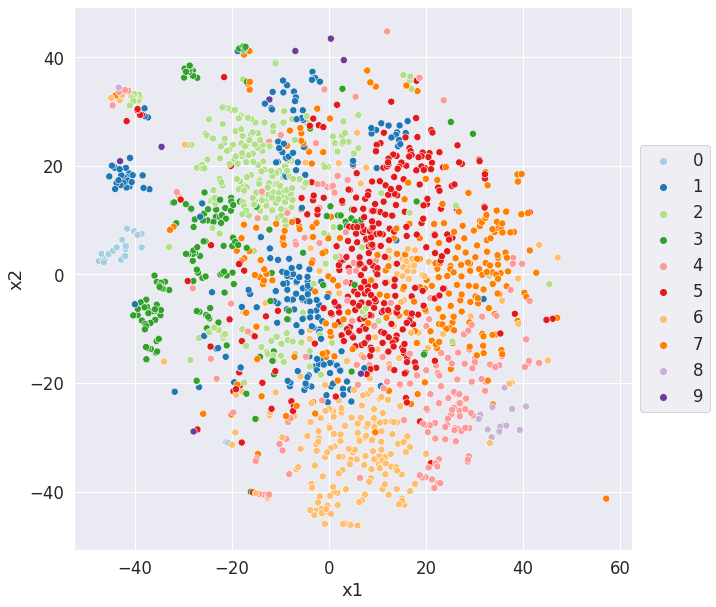

In [376]:
X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(data_s)

kmeans = KMeans(n_clusters=10, random_state=0).fit(data_s)

data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1]
           ,"year":var_year,
           "cluster":kmeans.labels_.astype(int),
          "country_name":var_country,'class':var_class}

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='cluster',
                     data=data_tSNE,
                     legend="full",
                     palette="Paired",
                     s=50,alpha=1).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

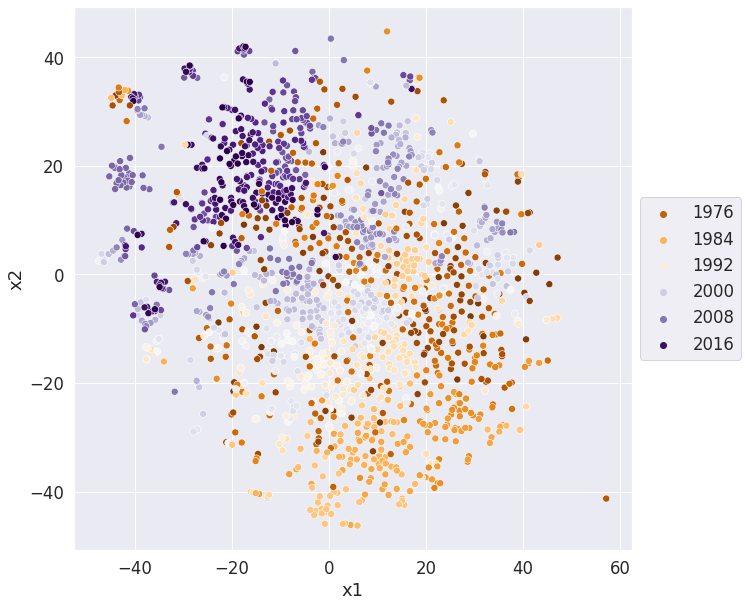

In [377]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='year',
                     data=data_tSNE,
                     palette="PuOr",
                     s=50,
                     alpha=1).legend(loc='center left',
                                           bbox_to_anchor=(1, 0.5),
                                           ncol=1)

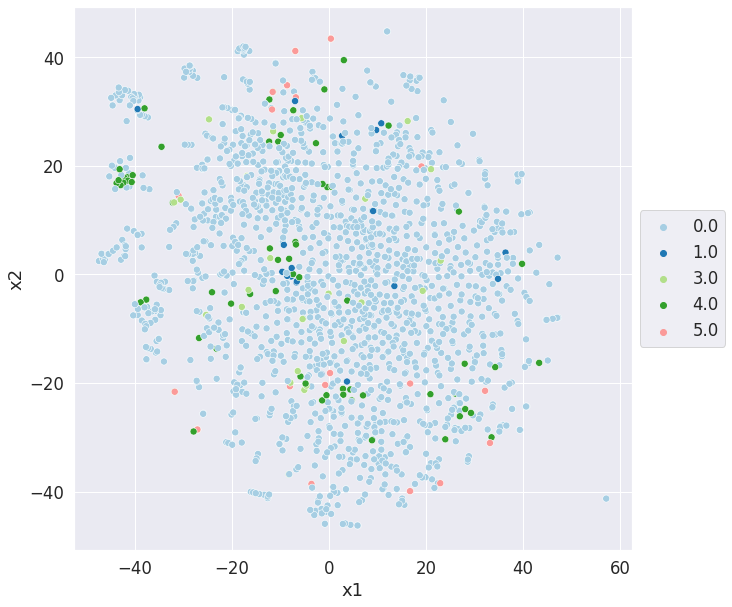

In [378]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE,legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

### Training Boost AE1



In [379]:
data_resid=boost_ae(input_data=data_s,encoder=[36,18,18,10]
       ,decoder=[10,18,18,36],hidden=4,train_set=0.8
       ,boost_n=1,loss='mae',noise=0,epochs=1000, batch_size=100,dropout_rate=0.5)

[1350, 1688]
Epoch 1/1000
14/14 [==============================] - 1s 40ms/step - loss: 0.6711 - val_loss: 0.6375
Epoch 2/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.6317 - val_loss: 0.6258
Epoch 3/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.6272 - val_loss: 0.6149
Epoch 4/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.6176 - val_loss: 0.6060
Epoch 5/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.6132 - val_loss: 0.6016
Epoch 6/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.6024 - val_loss: 0.5981
Epoch 7/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.6028 - val_loss: 0.5944
Epoch 8/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.6022 - val_loss: 0.5914
Epoch 9/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.5889 - val_loss: 0.5887
Epoch 10/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.5

In [380]:
data_resid_1=data_resid[0]
data_resid_1.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000
mean,-0.030962,-0.026786,-0.128659,0.001923,0.008148,-0.047659,-0.013223,0.223637,0.250987,0.010518,0.077958,0.115055,0.010567,-0.072518,0.152099,0.092154,0.088038,0.193753,-0.011010,0.337293,-0.044824,-0.021485,0.192270,0.222537,0.275037,0.226151,0.188892,-0.025281,0.220131,-0.051088,-0.001786,0.005978,0.196139,-0.013447,-0.051232,-0.049375,0.147109,-0.035237,-0.019851,0.101069,-0.038350,-0.253725,0.052153,-0.014078,0.085288,-0.074751,0.022250,0.029573,0.042702,0.075896,-0.006182,-0.049015,-0.007933,0.134596,0.201176,0.003724,0.009003,0.017399,-0.040292,-0.007755,0.096264,0.019660,0.115723,0.043696,0.024582,0.002652,-0.048096,-0.046518,0.016568,-0.012164,0.302291,0.046191,0.100832,-0.001190,0.056989
std,0.619411,0.534611,0.662475,0.759254,0.470052,0.926850,0.725228,0.861266,0.943850,0.998610,0.971035,0.942579,0.937763,0.912964,0.900827,0.993399,0.982620,1.000285,0.997067,0.965771,0.901819,0.896582,0.998330,0.932808,0.961539,0.971751,0.976239,0.998951,0.942873,0.893029,0.940229,0.995799,0.885613,0.992179,0.982492,0.946045,0.936306,0.920933,0.909001,0.885880,0.865098,0.944043,0.976608,0.917704,0.864374,0.904273,0.730266,0.787987,0.785141,0.906060,0.989200,0.996145,0.950511,0.987950,0.907520,0.998791,0.990261,0.763767,0.684030,0.813626,0.779155,0.993376,0.604772,0.886676,0.812662,0.974427,0.663271,0.587494,0.570777,0.579563,0.956010,0.793437,0.511235,0.788229,0.788559
min,-2.496643,-2.853745,-3.592813,-3.683671,-2.312731,-3.859755,-2.820757,-2.970794,-1.262420,-6.688674,-3.371245,-2.155106,-8.967280,-2.554181,-1.697457,-4.265968,-1.987356,-0.005324,-7.620003,-1.339125,-3.901715,-5.929744,-0.081868,-1.796237,-0.564501,-0.767278,-0.770366,-9.604266,-1.568346,-6.937109,-6.578253,-8.915730,-1.510031,-12.180665,-18.594201,-11.872266,-1.957099,-7.561439,-3.425116,-6.175612,-5.698088,-4.467339,-10.484901,-14.041232,-2.023761,-7.004923,-3.059726,-4.297539,-4.295929,-9.332619,-20.264725,-5.435108,-5.695279,-1.620487,-1.988857,-19.578015,-13.124642,-4.120145,-5.088748,-3.617089,-3.677618,-9.910451,-1.362673,-5.048980,-11.653760,-13.453309,-3.718613,-5.191911,-1.893798,-4.320140,-0.870351,-2.396302,-1.126906,-8.293205,-5.497453
25%,-0.278652,-0.200268,-0.322171,-0.373309,-0.204289,-0.335406,-0.391236,-0.323379,-0.276488,-0.373542,-0.198036,-0.521153,-0.158276,-0.719794,-0.466646,-0.240794,-0.502976,-0.000703,-0.184389,-0.278722,-0.580094,-0.468196,-0.013385,-0.404665,-0.078730,-0.205791,-0.177917,-0.275895,-0.318512,-0.403976,-0.372458,-0.306270,-0.296774,-0.349708,-0.073099,-0.362811,-0.405358,-0.297114,-0.510481,-0.271041,-0.467183,-0.396827,-0.215531,-0.384677,-0.479868,-0.371611,-0.354290,-0.342993,-0.325350,-0.395609,-0.052056,-0.480631,-0.444352,-0.035751,-0.323447,-0.087594,-0.274390,-0.346351,-0.361060,-0.463453,-0.321347,-0.428023,-0.106377,-0.337014,-0.240352,-0.337547,-0.315412,-0.284476,-0.293937,-0.288259,-0.142329,-0.383611,-

### Visualization (Round 1)

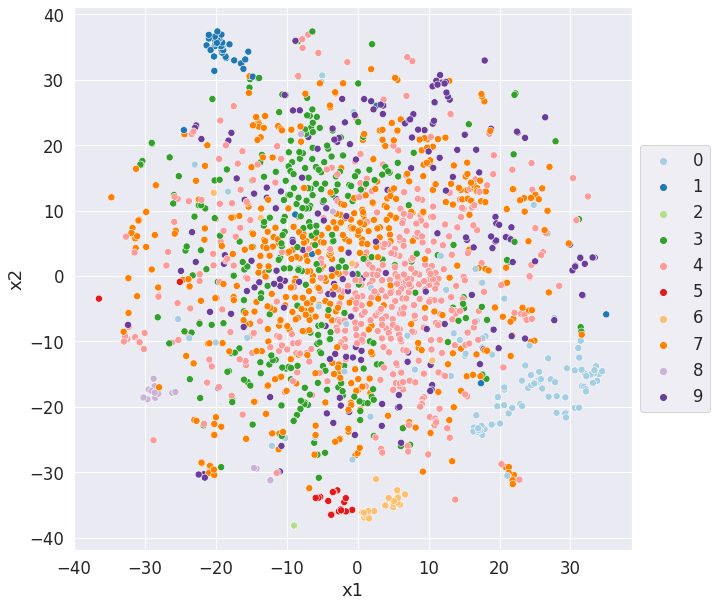

In [381]:
X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(data_resid_1)

kmeans = KMeans(n_clusters=10, random_state=0).fit(data_resid_1)

data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1]
           ,"year":var_year,
           "cluster":kmeans.labels_.astype(int),
          "country_name":var_country,'class':var_class}

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='cluster',
                     data=data_tSNE,
                     legend="full",
                     palette="Paired",
                     s=50,alpha=1).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

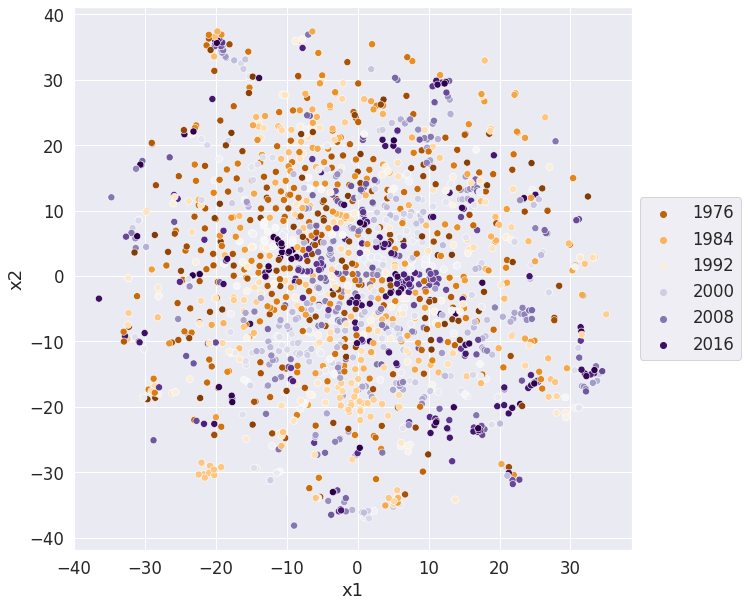

In [382]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='year',
                     data=data_tSNE,
                     palette="PuOr",
                     s=50,
                     alpha=1).legend(loc='center left',
                                           bbox_to_anchor=(1, 0.5),
                                           ncol=1)

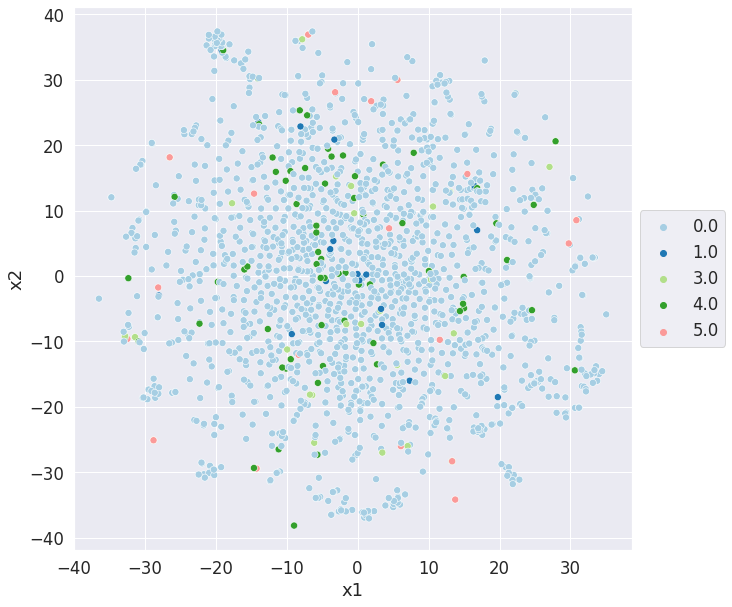

In [383]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE,legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

### SMOTE

In [384]:
x_r=data_resid_1.values
y_r=var_class.values
y_r[y_r!=0]=1

sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_r, y_r)

data_resid_smote=pd.DataFrame(x_res[:,0:data_resid_1.shape[1]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Visualizing SMOTE's results 

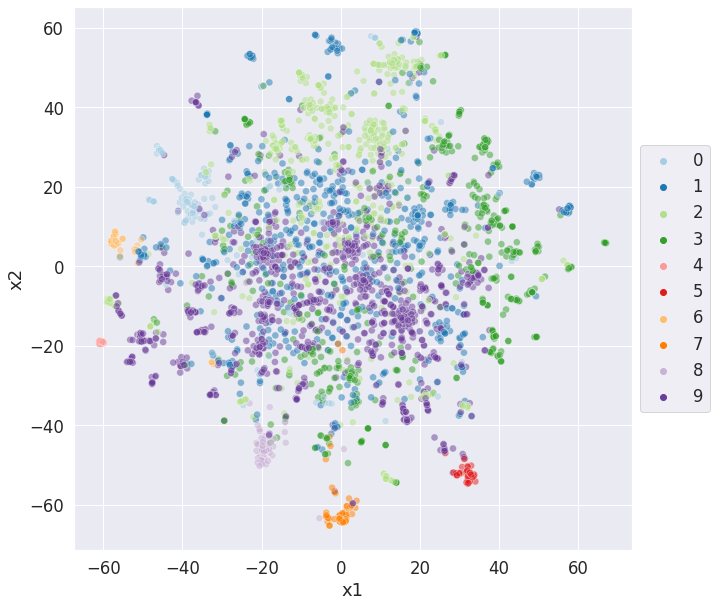

In [385]:
X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(data_resid_smote)

kmeans = KMeans(n_clusters=10, random_state=0).fit(data_resid_smote)

data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1],
           "cluster":kmeans.labels_.astype(int)}

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",y="x2",hue='cluster',
                     data=data_tSNE,
                     legend="full",
                     palette="Paired",
                     s=50,alpha=0.5).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

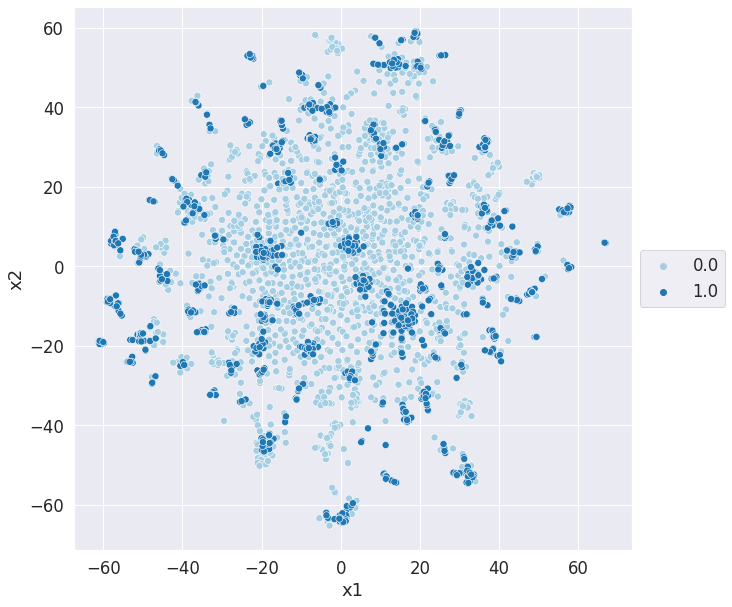

In [386]:
data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1],'class':y_res}

data_tSNE=pd.DataFrame(data_tSNE)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE,legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)


### Second AE

In [387]:
second_autoencoder,second_encoder=ae(input_data=data_resid_smote,encoder=[75,75,75,75]
       ,decoder=[75,75,75,75],hidden=50,train_set=0.8,loss='mae',noise=0.3,epochs=1000
       ,batch_size=1000,dropout_rate=0.5,activ='tanh')

[2462, 3078]
Epoch 1/1000
3/3 [==============================] - 1s 218ms/step - loss: 0.5112 - val_loss: 0.4629
Epoch 2/1000
3/3 [==============================] - 0s 45ms/step - loss: 0.4793 - val_loss: 0.4502
Epoch 3/1000
3/3 [==============================] - 0s 54ms/step - loss: 0.4604 - val_loss: 0.4431
Epoch 4/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.4532 - val_loss: 0.4378
Epoch 5/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.4463 - val_loss: 0.4333
Epoch 6/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.4429 - val_loss: 0.4295
Epoch 7/1000
3/3 [==============================] - 0s 48ms/step - loss: 0.4355 - val_loss: 0.4258
Epoch 8/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.4330 - val_loss: 0.4220
Epoch 9/1000
3/3 [==============================] - 0s 51ms/step - loss: 0.4288 - val_loss: 0.4185
Epoch 10/1000
3/3 [==============================] - 0s 49ms/step - loss: 0.4263 - val_loss: 0.

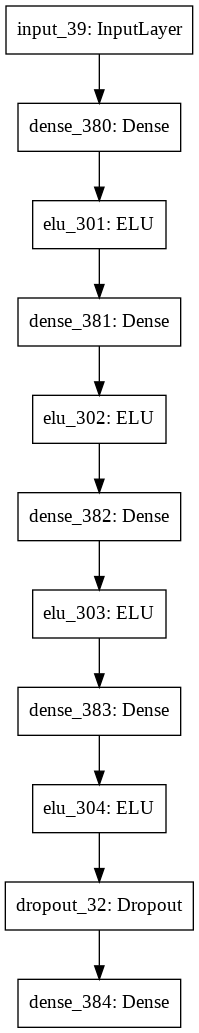

In [388]:
plot_model(second_encoder)

### Visualization

In [389]:
code=second_encoder.predict(data_resid_smote)

X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(code)

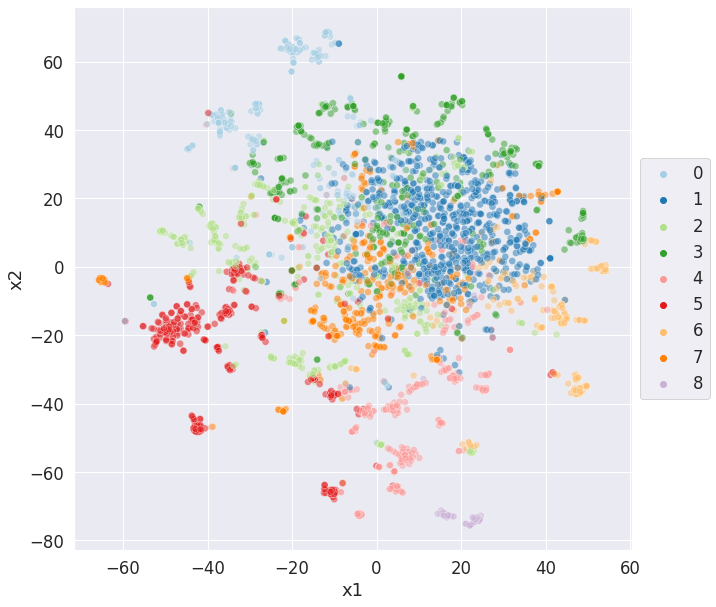

In [390]:
# number of clusters
k_cluster=9

kmeans = KMeans(n_clusters=k_cluster, random_state=0).fit(code)

data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1],
           "cluster":kmeans.labels_.astype(int)}

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",y="x2",hue='cluster',
                     data=data_tSNE,
                     legend="full",
                     palette="Paired",
                     s=50,alpha=0.5).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

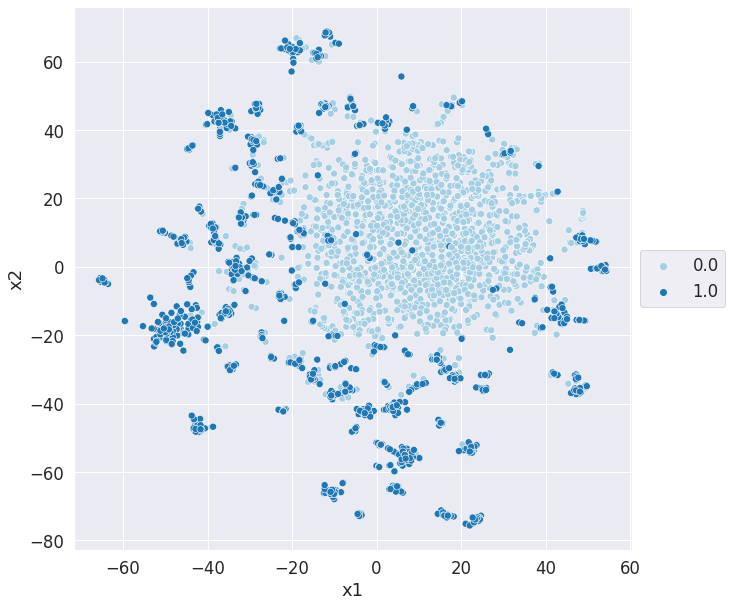

In [391]:
data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1],'class':y_res}

data_tSNE=pd.DataFrame(data_tSNE)

plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE,legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

### Mode Constrastive Auto Encoder

In [392]:
mcae_autoencoder,mcae_encoder=mcae(input_data=data_resid_smote,trained_encoder=second_encoder
                                   ,trained_autoencoder=second_autoencoder
         ,n_clusters=9,loss_f='mae',mc_weight=0.1
         ,maxiter = 40000,batch_size=1000,noise=0.3)

Iter 0:  ; loss= 0
Iter 800:  ; loss= [0.23133984208106995, 0.738265335559845, 0.1575133204460144]
Iter 1600:  ; loss= [0.193390354514122, 0.48887625336647034, 0.14450272917747498]
Iter 2400:  ; loss= [0.17106832563877106, 0.40825366973876953, 0.1302429586648941]
Iter 3200:  ; loss= [0.16017691791057587, 0.37149572372436523, 0.12302733957767487]
Iter 4000:  ; loss= [0.1628863364458084, 0.34813645482063293, 0.12807269394397736]
Iter 4800:  ; loss= [0.1479063779115677, 0.3276861011981964, 0.11513776332139969]
delta_label  0.0 < tol  1e-11
Reached threshold.
Iter 5600:  ; loss= [0.15079103410243988, 0.31630170345306396, 0.11916086077690125]
delta_label  0.0 < tol  1e-11
Reached threshold.
Iter 6400:  ; loss= [0.13757851719856262, 0.3033948838710785, 0.1072390228509903]
delta_label  0.0 < tol  1e-11
Reached threshold.
Iter 7200:  ; loss= [0.145185187458992, 0.330118328332901, 0.11217334866523743]
delta_label  0.0 < tol  1e-11
Reached threshold.
Iter 8000:  ; loss= [0.13682231307029724, 0.3

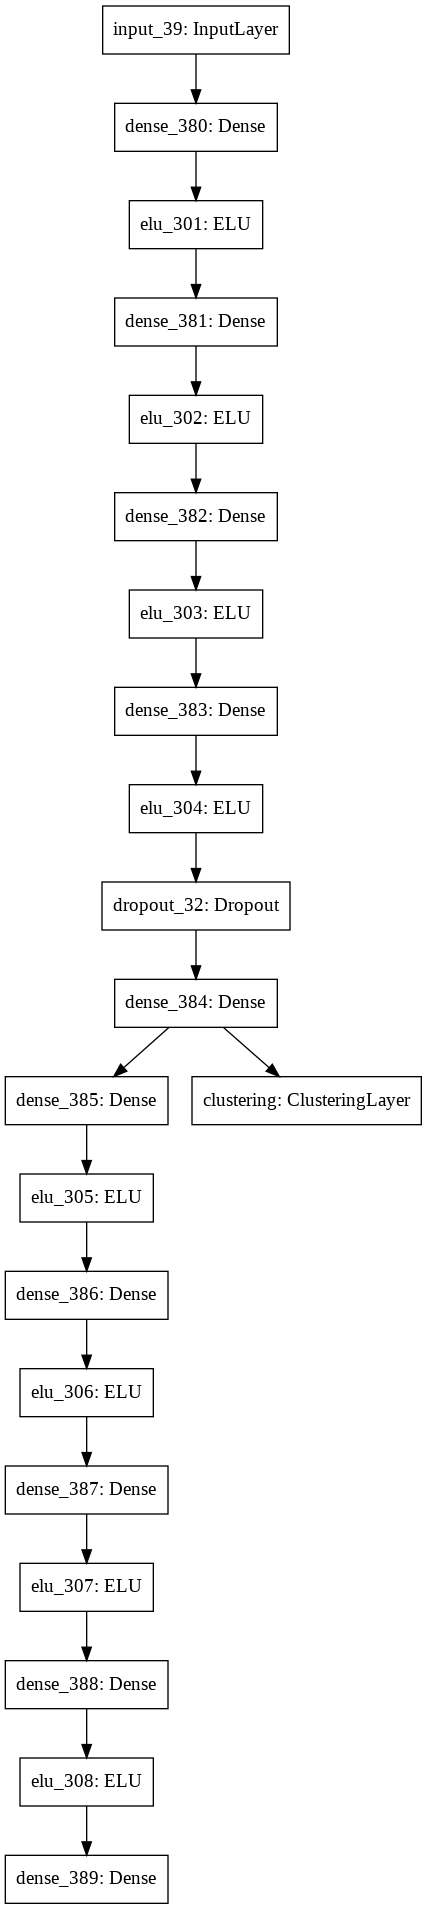

In [393]:
plot_model(mcae_autoencoder)

## Output clustering results

In [394]:
data_resid_1_copy=data_resid_1.copy()
data_resid_smote_copy=data_resid_smote.copy()

data_resid_1_copy['class']=data['class'].values.copy()
data_2=data_resid_1_copy[data_resid_1_copy['class']!=0].copy()

data_resid_smote_copy['class']=y_res*0.5
data_2=pd.concat([data_resid_smote_copy,data_2])
class_label=data_2['class'].values
data_2=data_2.drop(['class'], axis=1)

In [395]:
code=mcae_encoder.predict(data_2)

X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(code)

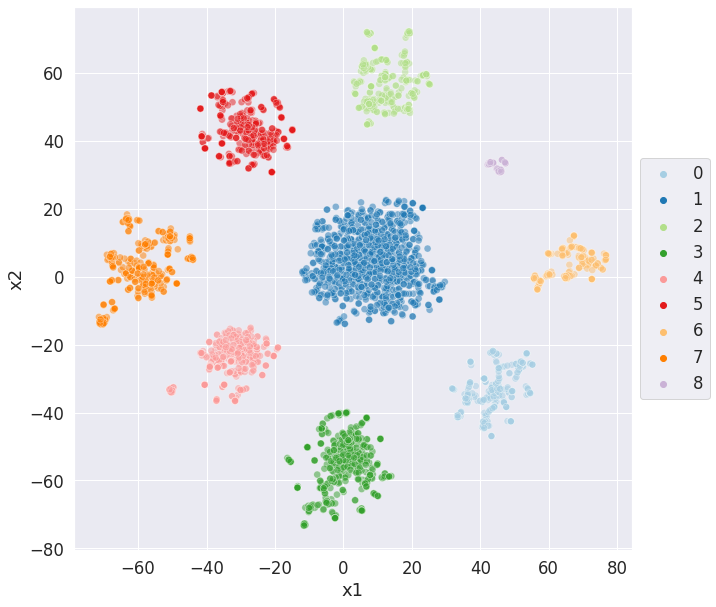

In [396]:
# Visualization

kmeans = KMeans(n_clusters=9, random_state=0).fit(code)

data_tSNE={'x1':X_embedded[:,0],'x2':X_embedded[:,1],
           "cluster":kmeans.labels_.astype(int),'class':class_label}

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='cluster',
                     data=data_tSNE,
                     legend="full",
                     palette="Paired",
                     s=50,alpha=0.5).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

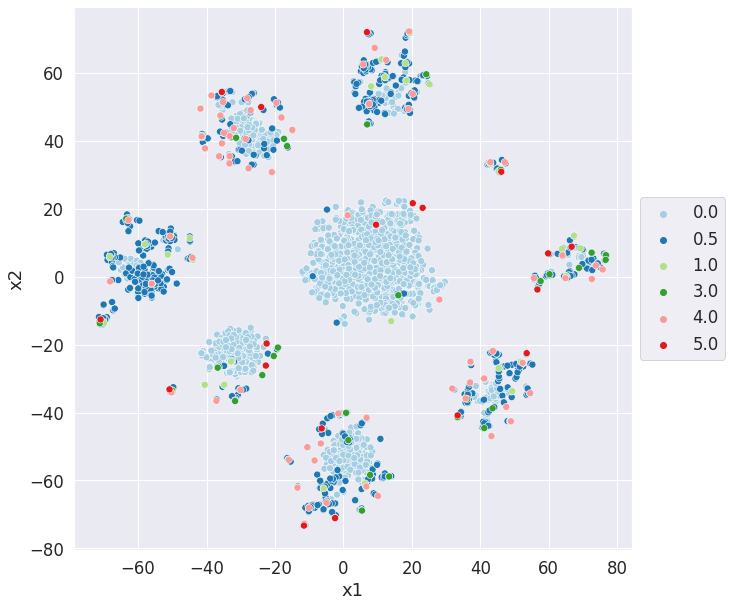

In [397]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE[data_tSNE['class']>-1],legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

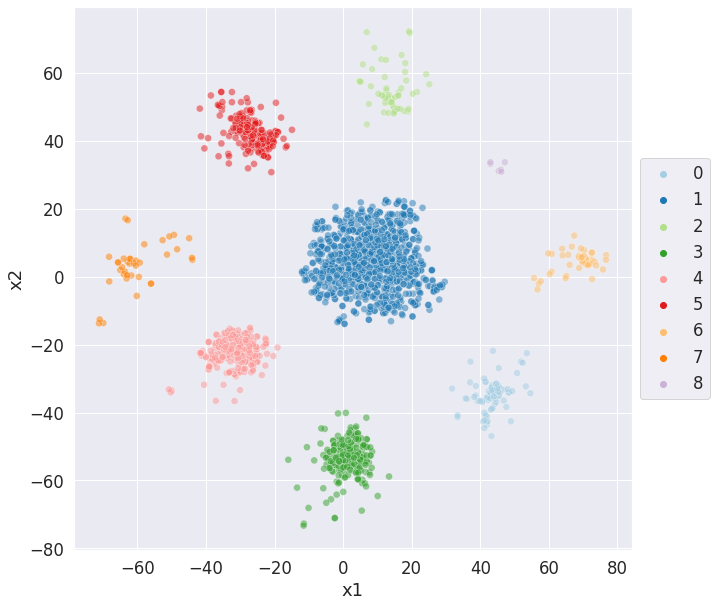

In [398]:
# Visualization

data_tSNE=pd.DataFrame(data_tSNE)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1",
                     y="x2",
                     hue='cluster',
                     data=data_tSNE[data_tSNE['class']!=0.5],
                     legend="full",
                     palette="Paired",
                     s=50,alpha=0.5).legend(loc='center left',
                                  bbox_to_anchor=(1, 0.5),
                                  ncol=1)

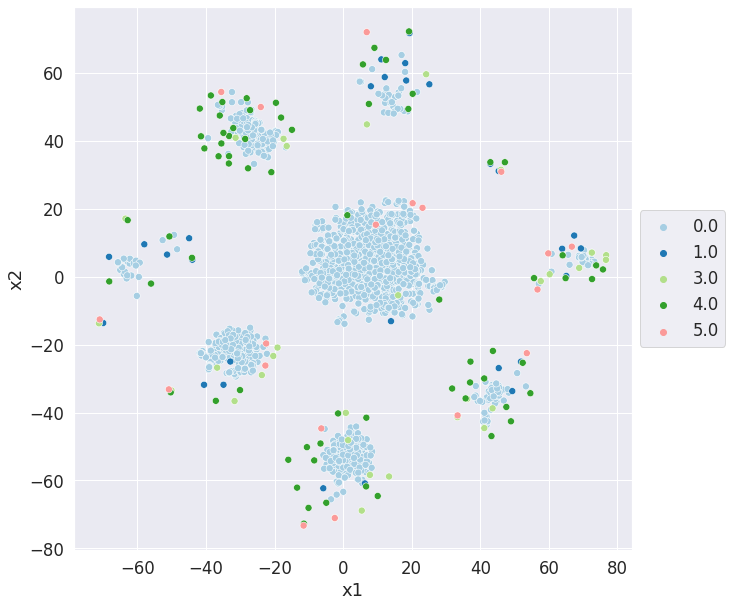

In [399]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="x1", y="x2",hue='class',alpha=1
                     , data=data_tSNE[data_tSNE['class']!=0.5],legend="full",
                     palette="Paired",s=50).legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [400]:
data_final=data_tSNE[data_tSNE['class']!=0.5].copy()
data_final['country']=np.concatenate((data[data['class']==0].country_name.values,data[data['class']!=0].country_name.values))
data_final['year']=np.concatenate((data[data['class']==0].year.values,data[data['class']!=0].year.values))
data_final

,x1,x2,cluster,class,country,year
0,-22.251709,37.992111,5,0.0,United States,1970.0
1,2.755578,7.874064,1,0.0,United States,1971.0
2,71.376755,3.828975,6,0.0,United States,1972.0
3,-32.903233,-19.830662,4,0.0,United States,1973.0
5,-26.126390,37.826252,5,0.0,United States,1975.0
...,...,...,...,...,...,...
3222,20.264601,21.622395,1,5.0,Slovenia,1983.0
3223,25.141518,56.626282,2,1.0,Slovenia,1992.0
3224,1.441896,-48.126953,3,3.0,Slovenia,2006.0
3225,-44.903469,11.311224,7,1.0,Slovenia,2008.0


In [424]:
cluster_num=2

noncrisis=data_tSNE[data_tSNE.cluster==cluster_num]['class'].value_counts()[0]
crisis=data_tSNE[data_tSNE.cluster==cluster_num]['class'].value_counts()[0.5]

# if risky?

print(['Risky cluster?',crisis>noncrisis])

data_final[data_final.cluster==cluster_num]['class'].value_counts()

['Risky cluster?', True]


0.0    41
4.0     7
1.0     7
3.0     2
5.0     1
Name: class, dtype: int64

In [425]:
#print the samples of crisis in all clusters

vis_cluster=data_final[(data_final['class']!=0)].copy()
vis_cluster[vis_cluster['cluster']==cluster_num].sort_values('year')

,x1,x2,cluster,class,country,year
3210,6.870670,71.979912,2,5.0,Czech Republic,1991.0
3223,25.141518,56.626282,2,1.0,Slovenia,1992.0
3199,24.210699,59.579166,2,3.0,Israel,1992.0
3082,11.134650,63.963928,2,1.0,United States,2007.0
3103,18.391569,57.744095,2,1.0,Germany,2008.0
3112,19.354057,71.703018,2,1.0,Luxembourg,2008.0
3115,12.129028,58.746902,2,1.0,Netherlands,2008.0
3133,8.084560,56.043457,2,1.0,Switzerland,2008.0
3083,12.498031,63.800877,2,4.0,United States,2008.0
3094,18.112383,62.855042,2,1.0,Belgium,2008.0
